In [1]:
import random
import math

import matplotlib.pyplot as plt
import networkx as nx
import numpy
from scipy.stats import linregress, ttest_1samp
from scipy.cluster.vq import kmeans2

random.seed(1)

In [2]:
# define network settings
population = 1000
initial_connections = 10
passes = 3#min([int(0.1 * population), 100])

In [3]:
# initialize belief states
belief_states = [random.randint(10, 50) * random.choice([-1, 1]) / 100 for i in range(population)]
next_belief_states = belief_states.copy()

outboxes = [set([(belief_states[i], i)]) for i in range(population)]
next_outboxes = outboxes.copy()

In [4]:
def connect(a, b):
  outbound_connections[a].add(b)
  inbound_connections[b].add(a)

def disconnect(a, b):
  outbound_connections[a].remove(b)
  inbound_connections[b].remove(a)

In [5]:
# initialize network
outbound_connections = [set() for indv in range(population)]
inbound_connections = [set() for indv in range(population)]

# start with Erdos-Renyi for first pass
everyone = range(population)
for indv in range(population):
    possible_connections = list(range(population))
    random.shuffle(possible_connections)
    for other in possible_connections[:1]:
        connect(indv, other)
    
            
# generate Barabasi-Albert network from random base
def get_connection_probabilities(depth=1):
    weight_of_neighbors = 0.5
    
    def get_path_count(indv, current_depth=0):
        num_paths_to_me = len(inbound_connections[indv])
        if current_depth <= depth:
            for other in inbound_connections[indv]:
                num_paths_to_me += weight_of_neighbors * get_path_count(other, current_depth + 1)
        return num_paths_to_me
    
    all_path_counts = [get_path_count(indv) for indv in everyone]
    sum_path_counts = sum(all_path_counts)
    connection_probabilities = [count / sum_path_counts for count in all_path_counts]
    return connection_probabilities

for i in range(passes - 1): # first pass has already happened
    connection_probabilities = get_connection_probabilities()
    for indv in everyone:
        for other, prob in enumerate(connection_probabilities):
            if len(outbound_connections[indv]) >= initial_connections:
                break
            if (random.random() <= prob) and (indv != other):
                connect(indv, other)

R^2: 0.8099742294251973


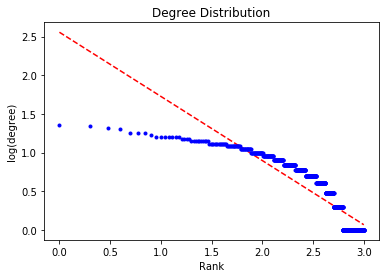

In [6]:
# plot power law distribution
degrees = sorted([math.log10(len(inbound_connections[i]) + 1) for i in range(population)], reverse=True)
ranks = [math.log10(r + 1) for r in range(population)]

z = numpy.polyfit(ranks, degrees, 1)
p = numpy.poly1d(z)
plt.plot(ranks, p(ranks),"r--")

r_value = linregress(ranks, degrees)[2]
r2 = r_value ** 2

print("R^2:", r2)

plt.plot(ranks, degrees, "b.")
plt.xlabel("Rank")
plt.ylabel("log(degree)")
plt.title("Degree Distribution")
plt.show()

In [7]:
def visualize_graph():
    G = nx.DiGraph()
    G.add_nodes_from(range(population))

    edges = []
    for indv, ocs in enumerate(outbound_connections):
        for other in ocs:
            edge = (indv, other)
            edges.append(edge)
            G.add_edge(indv, other)

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, edge_color = 'b', arrowsize=20, arrowstyle='->')
    plt.show()
    
    return edges

#edges = visualize_graph()
#print(edges)
#dict(zip(*get_order()))

In [8]:
disconnect_threshold = 0.3
follow_threshold = 0.1
reshare_threshold = 0.2

In [9]:
def update(inbox_size):
  global outboxes, next_outboxes, belief_states, next_belief_states

  for indv in range(population):
    inbox = []
    conns = sorted(outbound_connections[indv], key=lambda other: abs(belief_states[other] - belief_states[indv]))
    for other in conns:
      inbox += outboxes[other]

    state = belief_states[indv]
    for post in inbox[:inbox_size]:
      msg, author = post
    
      disagreement = abs(msg - state)
      memory = abs(belief_states[indv]) / 0.5
      #memory = 1 / (1 + math.e ** (-4 * abs(belief_states[indv])))
        
      state = memory * state + (1 - memory) * msg

      if disagreement > disconnect_threshold:
        if author in outbound_connections[indv]:
          disconnect(indv, author)
          #print(indv, "unfollowed", author)
      if disagreement < follow_threshold:
        connect(indv, author)
        #print(indv, "followed", author)
      if disagreement < reshare_threshold and len(next_outboxes[indv]) < 10:
        next_outboxes[indv].add((msg, author))
        #print(indv, "reshared")

    assert abs(state) <= 0.5, "belief state too extreme"
    
    #state = math.copysign(min([0.5, abs(1.01 * state)]), state)
    
    next_belief_states[indv] = state
    
    confidence = abs(belief_states[indv]) / 0.5

    if random.random() <= confidence:
      next_outboxes[indv].add((next_belief_states[indv], indv))

  belief_states = next_belief_states.copy()
  outboxes = next_outboxes.copy()
  next_outboxes = [set() for i in range(population)]

In [10]:
sim_length = 100
for i in range(sim_length + 1):
  if i < 0:
    update(30)
  else:
    update(population)
  if i % (0.1 * sim_length) == 0:
    print(f"{int(100 * i / sim_length)}%", end="")
  elif i % int(0.01 * sim_length) == 0:
    print(".", end="")


0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100%

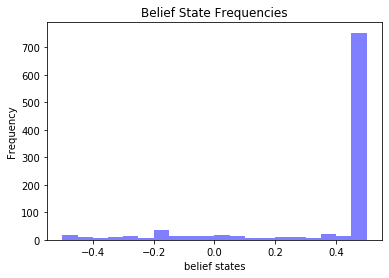

82.22310044642992% polarization


In [11]:
# https://jimgrange.files.wordpress.com/2015/12/ttable.png

num_bins = 20
n, bins, patches = plt.hist(belief_states, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel("belief states")
plt.ylabel("Frequency")
plt.title("Belief State Frequencies")
plt.show()

# measure polarization
left = [s for s in belief_states if s < 0]
right = [s for s in belief_states if s > 0]
leftists = len(left)
rightists = len(right)
left_mean = sum(left) / leftists
right_mean = sum(right) / rightists

print(f"{abs(((leftists / (population / 2)) * left_mean - (rightists / (population / 2)) * right_mean) * 100)}% polarization")

Political polarization does occur.

In [12]:
set_a = range(5)
set_b = range(5, 10)
ttest_1samp(set_a, 2)

Ttest_1sampResult(statistic=0.0, pvalue=1.0)

R^2: 0.47509378185311946


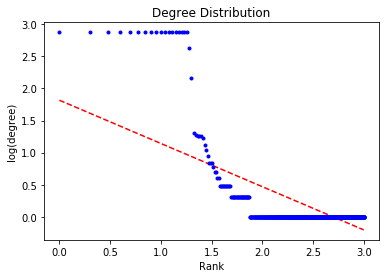

In [13]:
# plot power law distribution
degrees = sorted([math.log10(len(inbound_connections[i]) + 1) for i in range(population)], reverse=True)
ranks = [math.log10(r + 1) for r in range(population)]

z = numpy.polyfit(ranks, degrees, 1)
p = numpy.poly1d(z)
plt.plot(ranks, p(ranks),"r--")

r_value = linregress(ranks, degrees)[2]
r2 = r_value ** 2

print("R^2:", r2)

plt.plot(ranks, degrees, "b.")
plt.xlabel("Rank")
plt.ylabel("log(degree)")
plt.title("Degree Distribution")
plt.show()

0.1265466816647919


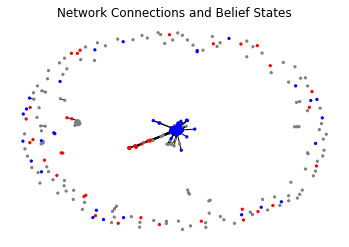

In [14]:
G = nx.Graph()
G.add_nodes_from(range(population))
edges = set()
cross_edges = set()
for indv, conns in enumerate(outbound_connections):
  for other in conns:
    if (belief_states[indv] < 0 and belief_states[other] > 0) or (belief_states[indv] > 0 and belief_states[other] < 0):
      cross_edges.add((indv, other))
    edges.add((indv, other))
print(len(cross_edges) / len(edges) * 100)


color_map = []
for node in G:
  if belief_states[node] >= 0.3:
    color_map.append('blue')
  elif belief_states[node] <= -0.3:
    color_map.append('red')
  else:
    color_map.append('gray')

def width(edge):
  if edge in cross_edges:
    return 1
  return 1

G.add_edges_from(edges)
plt.title("Network Connections and Belief States")
layout = nx.spring_layout(G)
nx.draw(G, node_color=color_map, pos=layout, node_size=5, width=[width(edge) for edge in G.edges()])

Show relationship between time and the following:

* polarity
* \# cross edges / # edges
* degree distribution R^2 (maybe)

Also tweak the following:

* network size
* thresholds
* confidence calculation

Even without showing fission/full polarization I want be able to argue that they will occur based on my results. However, geography may be something that is simply not present in the network.